# Data Analysis
The goal of this notebook is to discover patterns in the dataSet, that will help selecting relevant variables and doing efficient preprocessing on the data.

In [32]:
# standard 
import os
import datetime as dt
from math import *

# external
import numpy as np
import pandas as pd
from hijri_converter import Hijri, Gregorian
import ephem


# Stats
from statsmodels.tsa.stattools import adfuller
from scipy.fftpack import fft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-bright')
palette = sns.color_palette("rocket_r")

### Loading data

In [33]:
df = pd.read_csv("./data/original_data/data.txt", sep = "     ",index_col = None)

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [34]:
df.head()

,COEF_MAREE UT: 0.0
2000-01-01 12:21:00,48
2000-01-02 00:53:00,50
2000-01-02 13:19:00,53
2000-01-03 01:45:00,56
2000-01-03 14:08:00,60


Above we have a serie of calculated tidal coefficients. The last are coefficients that tell us the amplitude of the tide forecast (difference in height between the consecutive high tides and low tides in any given area). They are calculated from a series of temporal data obtained from mareographs in previous years. This series of data could be adapted by the method of least squares using Foreman's algorithm (Foreman, M.G.G., 1977. Manual for Tidal Heights Analysis and Prediction).
- Objectif of this project: 
    - Forcasting new future tidal coefficients using a long serie of calculated coefficients.

### Data info
Cheking data type and NaN values.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15292 entries, 2000-01-01 12:21:00 to 2021-08-31 22:24:00
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COEF_MAREE   UT: 0.0  15292 non-null  int64
dtypes: int64(1)
memory usage: 238.9+ KB


- There are no NaN values in the dataSet

In [36]:
df.describe()

,COEF_MAREE UT: 0.0
count,15292.000000
mean,69.799045
std,20.370253
min,22.000000
25%,53.000000
50%,71.000000
75%,85.000000
max,118.000000


- Normal tidal coefficients are between  20 and 120. We don't see any strange values(values that lie outside this range) in the dataSet.

In [37]:
df.reset_index(inplace = True)
df.rename(columns = {'index':'dateTime', 'COEF_MAREE   UT: 0.0':'coef'}, inplace = True)
df.head()

,dateTime,coef
0,2000-01-01 12:21:00,48
1,2000-01-02 00:53:00,50
2,2000-01-02 13:19:00,53
3,2000-01-03 01:45:00,56
4,2000-01-03 14:08:00,60


### Adding Date-Time related features
Date, Time-related features help understanding patterns in the dataSet.
- Since tidal phenomena is due to both sun's attraction and moon's attraction, it would be intersting to explore patterns in the dataSet using hirji calendar which is basically calculated using the moon phases.

In [38]:
df['dateTime'] = pd.to_datetime(df['dateTime'])
df['date'] = df['dateTime'].dt.date.values
df['time'] = df["dateTime"].dt.time.values
df['day'] = df['dateTime'].dt.day.values
df['month'] = df['dateTime'].dt.month.values
df['year'] = df['dateTime'].dt.year.values
df['hijri_day'] = df['date'].apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().day)
df['hijri_month'] = df['date'].apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().month)
df['hijri_year'] = df['date'].apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().year)
df['quarter'] = df['dateTime'].dt.quarter.values
df['hour'] = df['dateTime'].dt.hour.values


In [39]:
df.head()

,dateTime,coef,date,time,day,month,year,hijri_day,hijri_month,hijri_year,quarter,hour
0,2000-01-01 12:21:00,48,2000-01-01,12:21:00,1,1,2000,24,9,1420,1,12
1,2000-01-02 00:53:00,50,2000-01-02,00:53:00,2,1,2000,25,9,1420,1,0
2,2000-01-02 13:19:00,53,2000-01-02,13:19:00,2,1,2000,25,9,1420,1,13
3,2000-01-03 01:45:00,56,2000-01-03,01:45:00,3,1,2000,26,9,1420,1,1
4,2000-01-03 14:08:00,60,2000-01-03,14:08:00,3,1,2000,26,9,1420,1,14


In [40]:
df.hijri_year.max()

1443

#### 

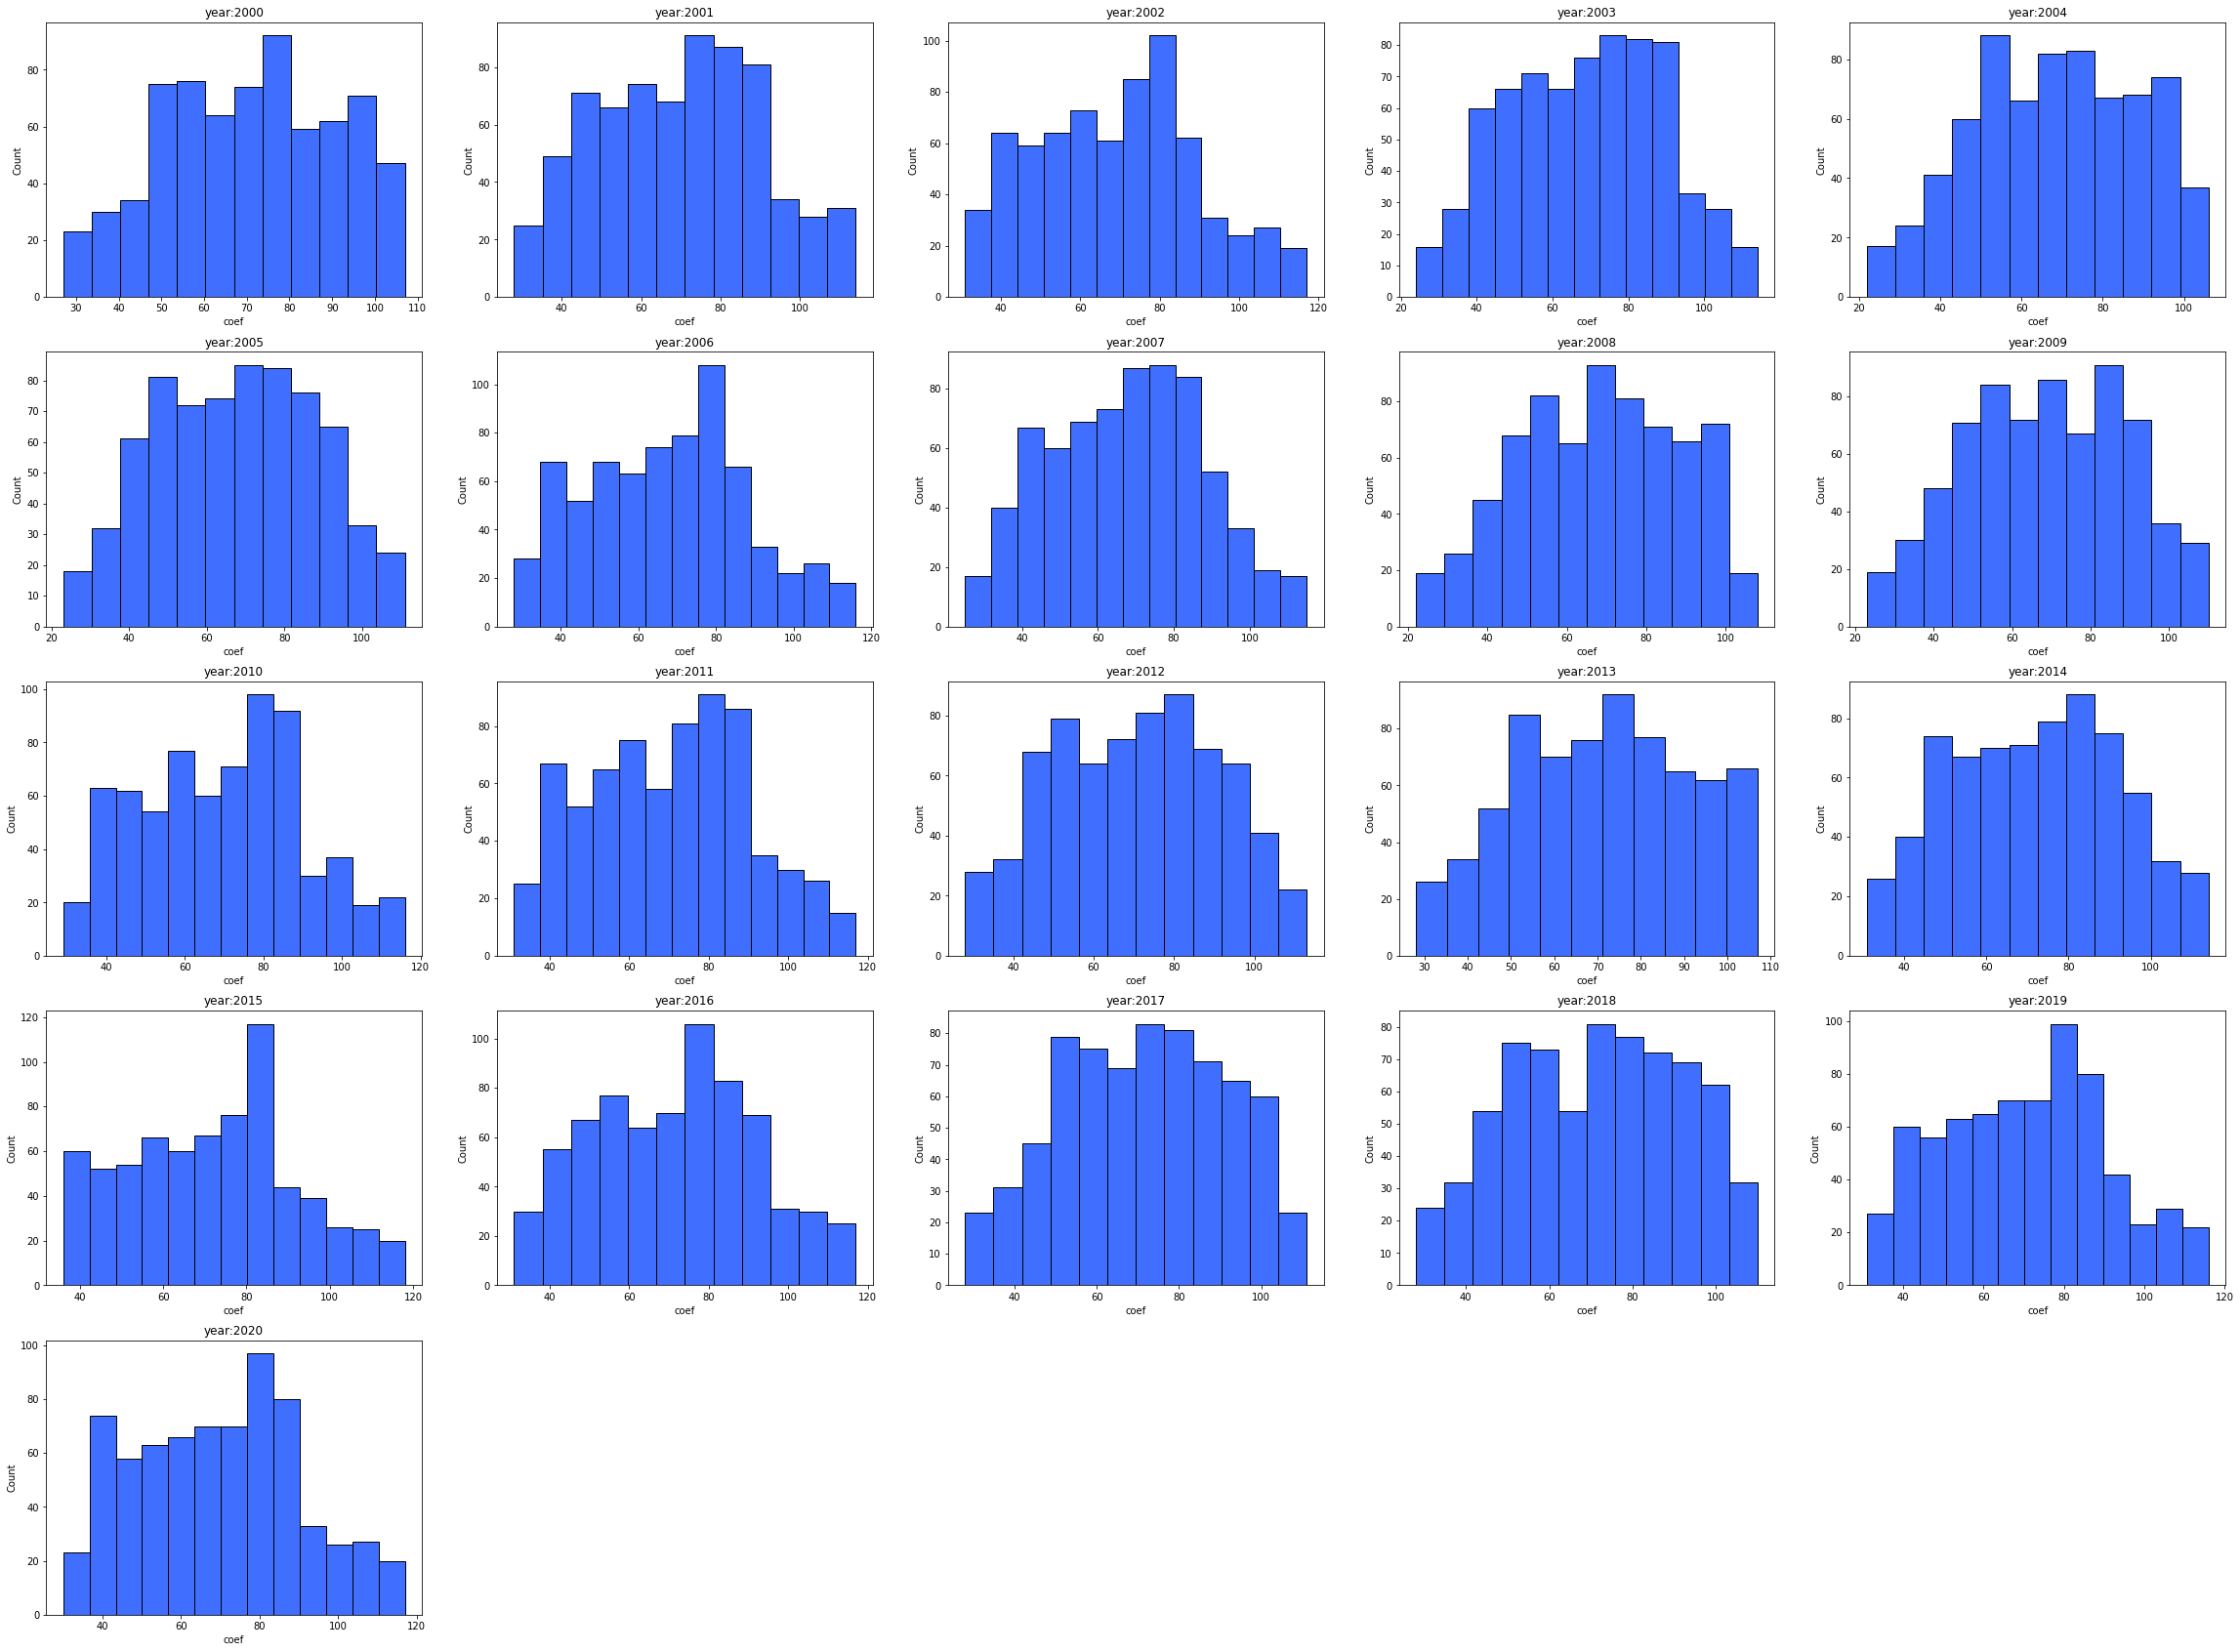

In [41]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(40,30))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    sns.histplot(data["coef"])
    plt.title("year:"+ str(years[i]))

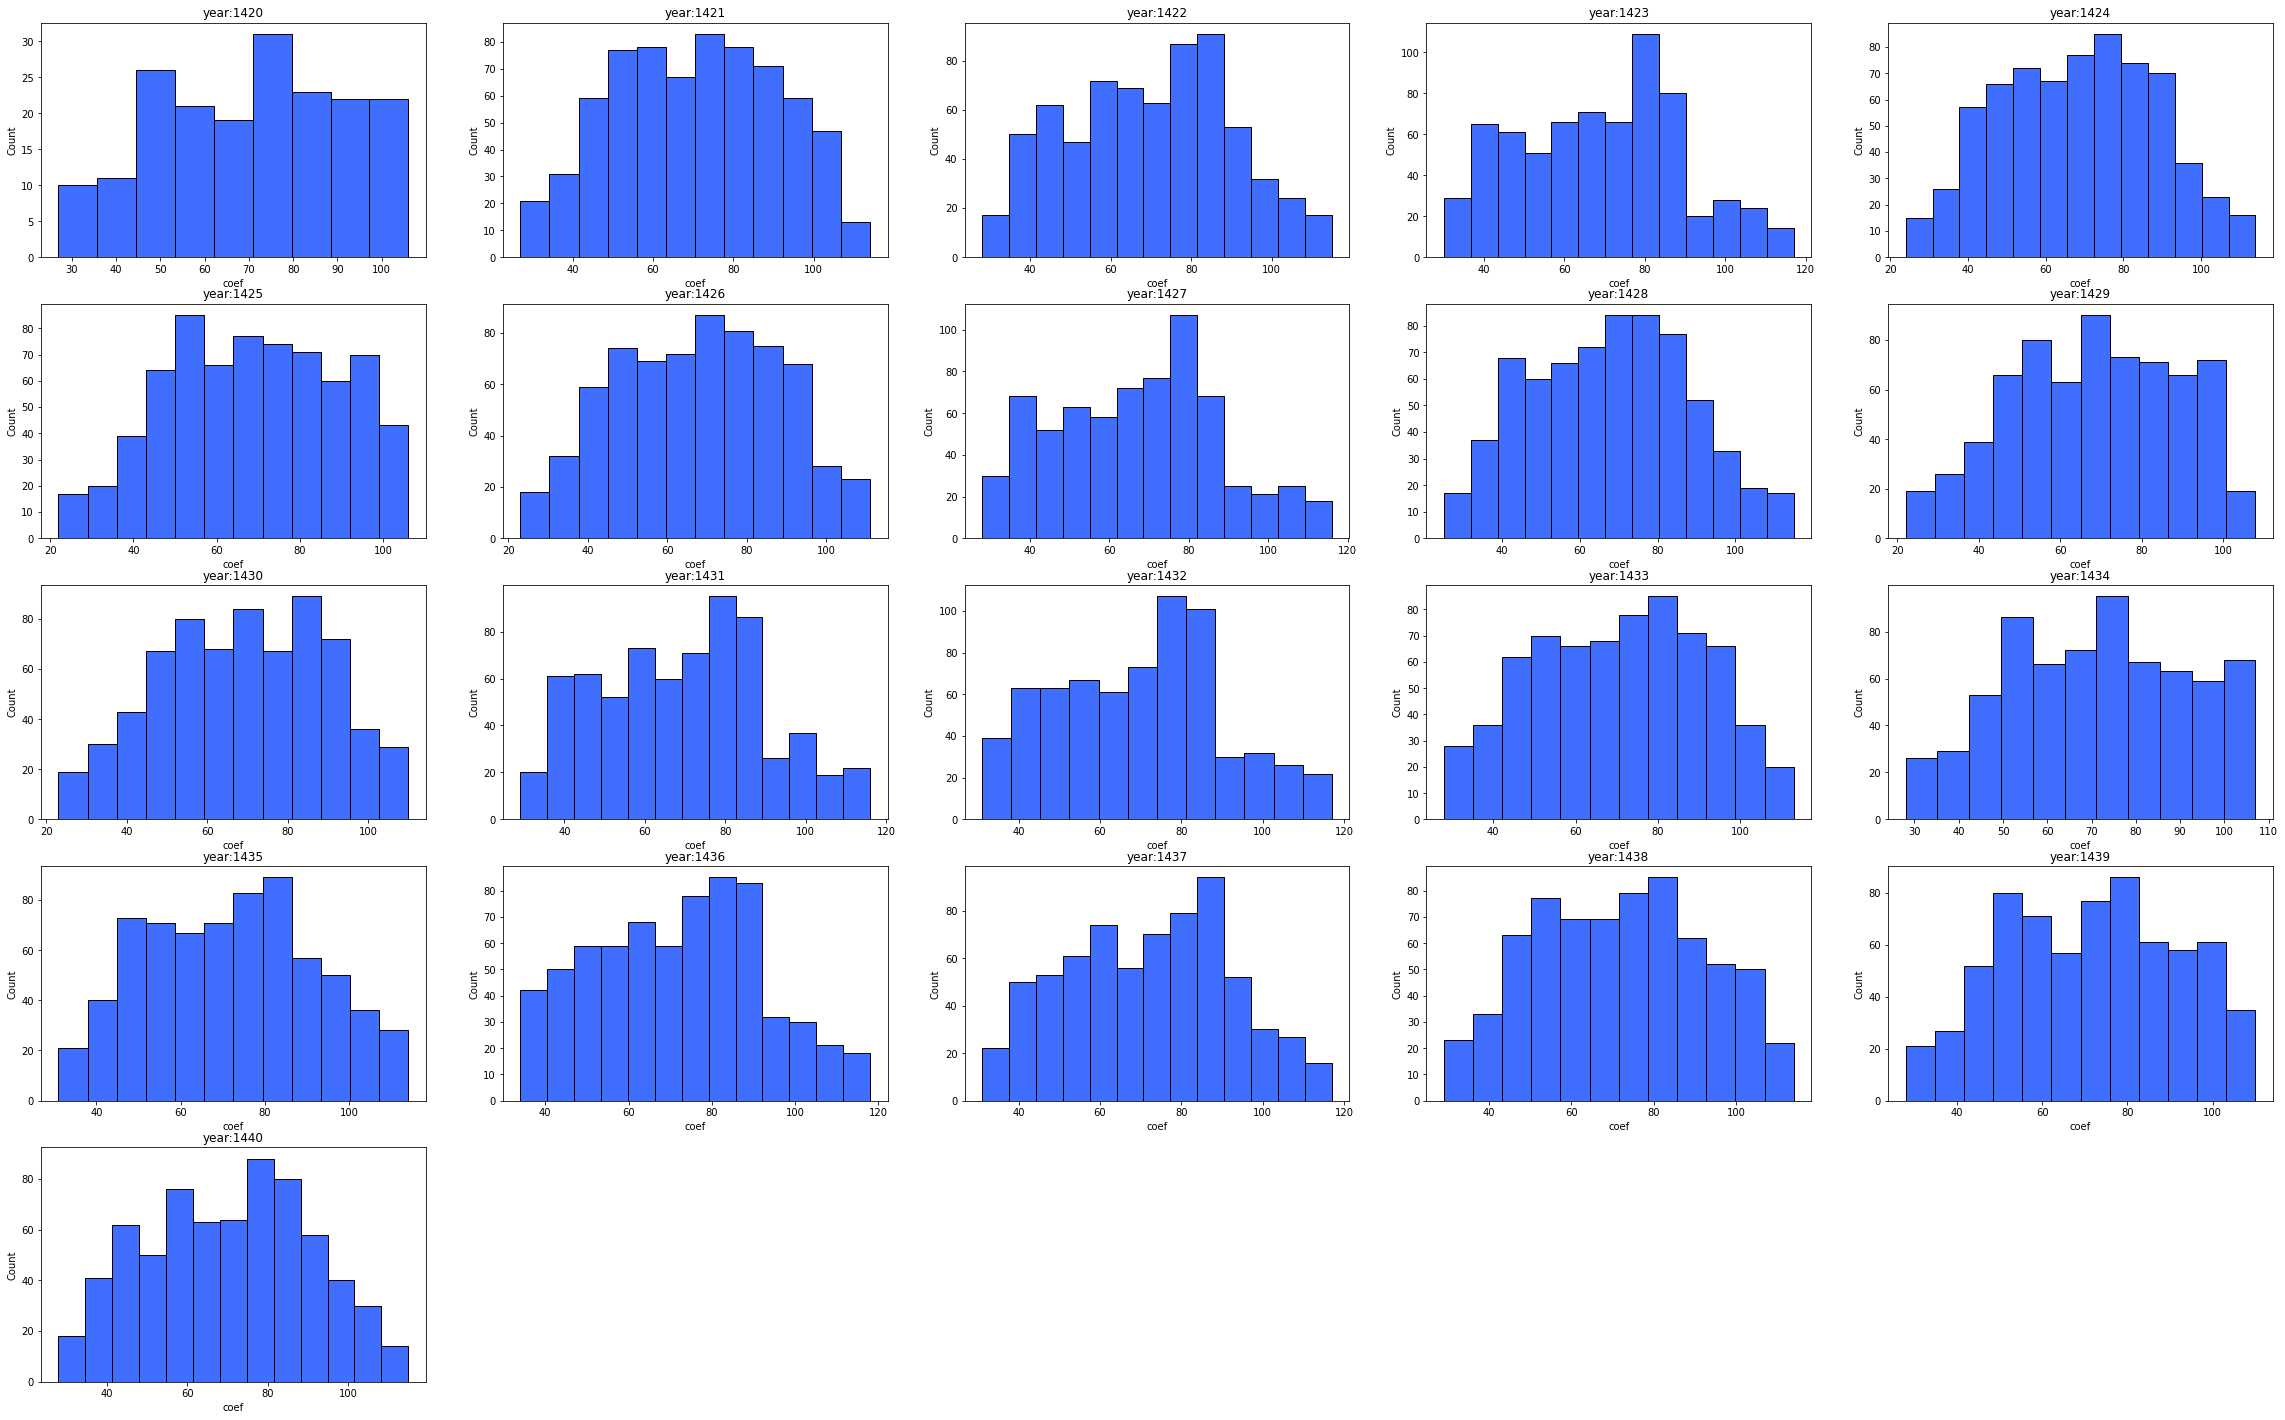

In [42]:
hijri_years = np.arange(df.hijri_year.min(),df.hijri_year.max(), 1)
plt.figure(figsize=(40,25))
for i in range(21):
    data = df[df["hijri_year"] == hijri_years[i]]
    plt.subplot(5,5,i+1)
    sns.histplot(data["coef"])
    plt.title("year:"+ str(hijri_years[i]))

### How does the distribution of tidal coefficients changes over months?

<Figure size 2880x1440 with 0 Axes>

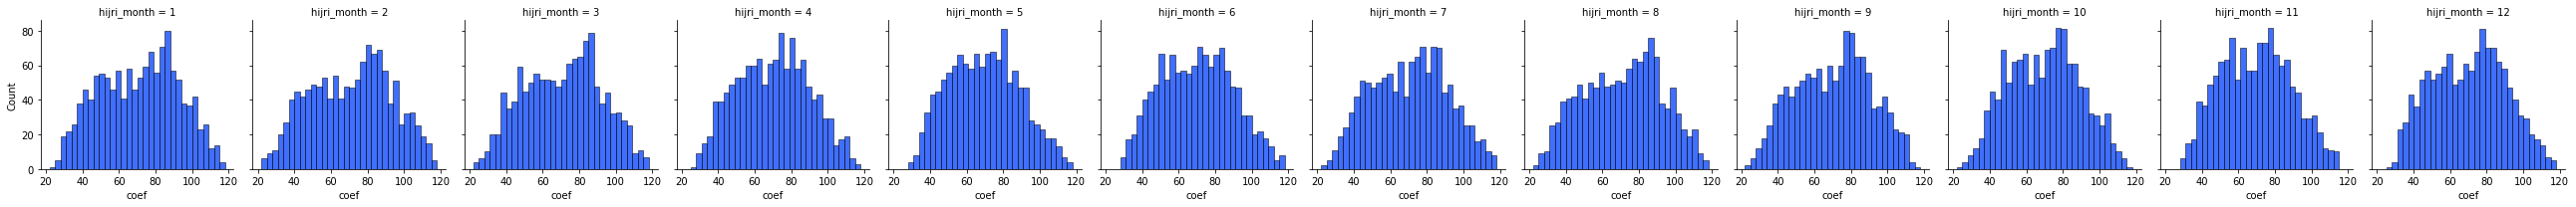

In [43]:
plt.figure(figsize=(40,20))
sns.displot(
    df, x="coef", col="hijri_month",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True)
)

<Figure size 2880x1440 with 0 Axes>

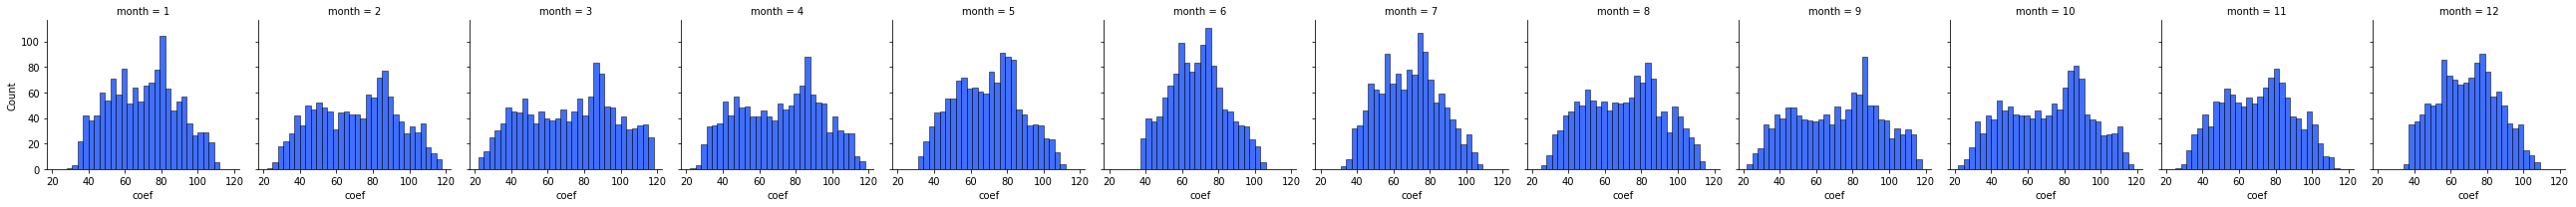

In [44]:
plt.figure(figsize=(40,20))
sns.displot(
    df, x="coef", col="month",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True)
)

- ALL hijri months have roughly the same distribution of tidal coeffcients. (quite similar shapes and ranges)
- In contrast Gregorian months have quite different distributions. (differents shapes and ranges)

### Is there any relation between the coefficients of a the months of two given years?

In [45]:
df[df["hijri_year"]==1440][df["hijri_month"]==6]["coef"].shape

C:\Users\Otmane\AppData\Local\Temp/ipykernel_20668/858922122.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["hijri_year"]==1440][df["hijri_month"]==6]["coef"].shape


(58,)

In [46]:
df[df["hijri_year"]==1441][df["hijri_month"]==6]["coef"].shape

C:\Users\Otmane\AppData\Local\Temp/ipykernel_20668/4087242413.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["hijri_year"]==1441][df["hijri_month"]==6]["coef"].shape


(58,)

C:\Users\Otmane\AppData\Local\Temp/ipykernel_20668/804550913.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df[df["hijri_year"]==1432][df["hijri_month"]==5]["coef"], df[df["hijri_year"]==1442][df["hijri_month"]==5]["coef"]);


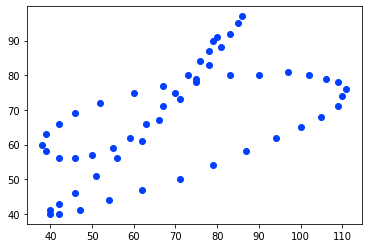

In [47]:
plt.scatter(df[df["hijri_year"]==1432][df["hijri_month"]==5]["coef"], df[df["hijri_year"]==1442][df["hijri_month"]==5]["coef"]);

C:\Users\Otmane\AppData\Local\Temp/ipykernel_20668/310169037.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df[df["year"]==2002][df["month"]==5]["coef"], df[df["year"]==2003][df["month"]==5]["coef"]);


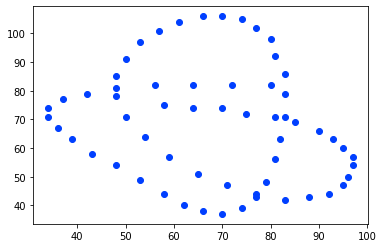

In [48]:
plt.scatter(df[df["year"]==2002][df["month"]==5]["coef"], df[df["year"]==2003][df["month"]==5]["coef"]);

- There is no clear relationship between 2 months of a given 2 years.(Using both hirji and gregorian calendars)

In [49]:
hijri_months = np.arange(df.hijri_month.min(),df.hijri_month.max(), 1)
plt.figure(figsize=(40,35))
for i in range(11):
    data = df[df["hijri_month"] == hijri_months[i]]
    plt.subplot(4,3,i+1)
    sns.boxplot(x="hijri_year", y="coef", data=data)
    plt.title("month: "+ str(hijri_months[i]))

- The distribution of the coefficients for a given month changes from year to year. (no clear pattern)
- We could notice some high values for :
    - month 6 : year 1429
    - month 9 : year 1438


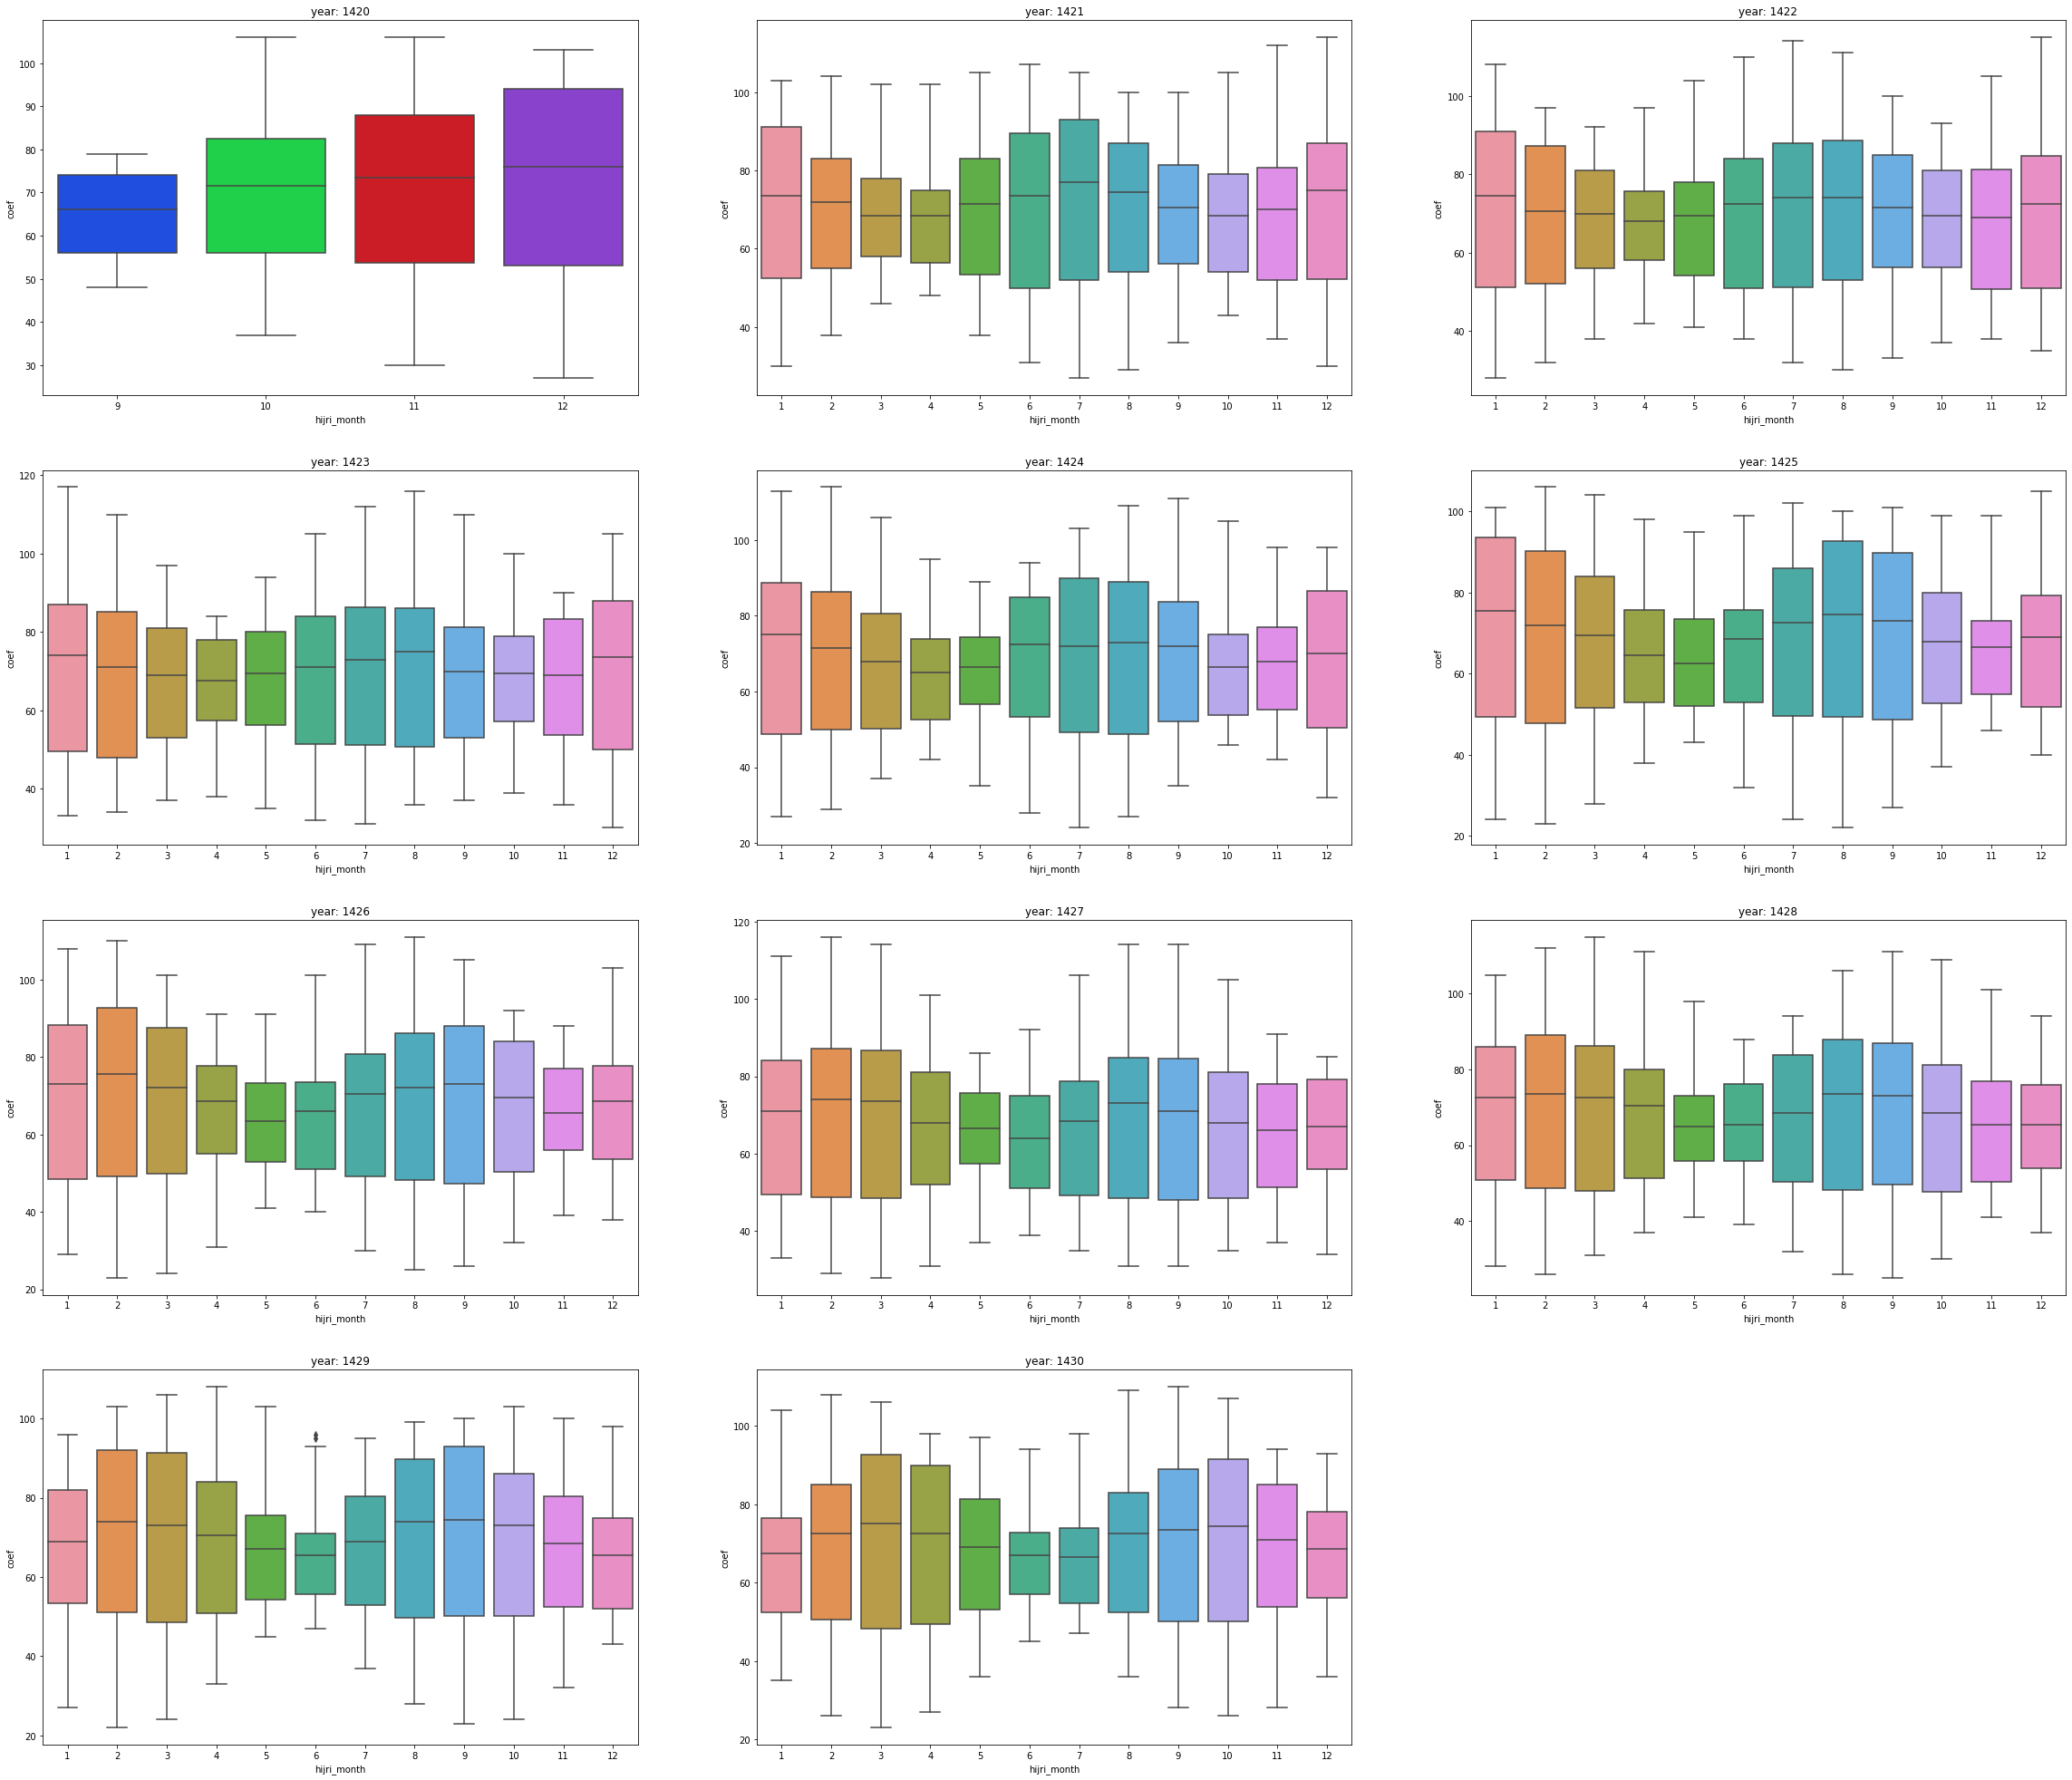

In [ ]:
hijri_years = np.arange(df.hijri_year.min(),df.hijri_year.max(), 1)
plt.figure(figsize=(40,35))
for i in range(11):
    data = df[df["hijri_year"] == hijri_years[i]]
    plt.subplot(4,3,i+1)
    sns.boxplot(x="hijri_month", y="coef", data=data)
    plt.title("year: "+ str(hijri_years[i]))

- We could notice some remarquable patterns:
    - Periodic change in the coefficients range over the 21 years 
    - Each year represent one periode of variation, for example in the plot representing the year 1421, we could notice 1/4*T (where T=1 year is the periode) from month 1 to month 3 and 1/2*T from month 
    4 to month 9 and last 1/4*T from month 10 to month 12.

Conclusion: Strong seasonal effect.

### Correlation with the moon and the sun related features?

Phases and tides:
- During the full moon and new moon phases, the Moon and the Sun are aligned and their effects combined, producing the spring tides.
- During waxing and waning moons, on the contrary, the effects are detracted, thereby obtaining tides of less amplitude (lower tidal coefficient), called neap tides.

In [ ]:
moon = ephem.Moon()
moon.compute("2021-11-17")
moon.libration_lat

0.06516138935107942

In [ ]:
# Moon related features
def getMoonPhase(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.moon_phase

def getMoonDistance(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.earth_distance

def getMoonSunDistance(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.sun_distance

def getMoonLibrationLatitude(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.libration_lat

def getMoonLibrationLongitude(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.libration_long

def getMoonSubSolarLatitude(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.subsolar_lat

def getMoonElongation(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.elong

# Sun related features
def getSunEarthDistance(date):
    sun = ephem.Sun()
    sun.compute(date)
    return sun.earth_distance

### Is the time serie of tidal coefficients stationary?


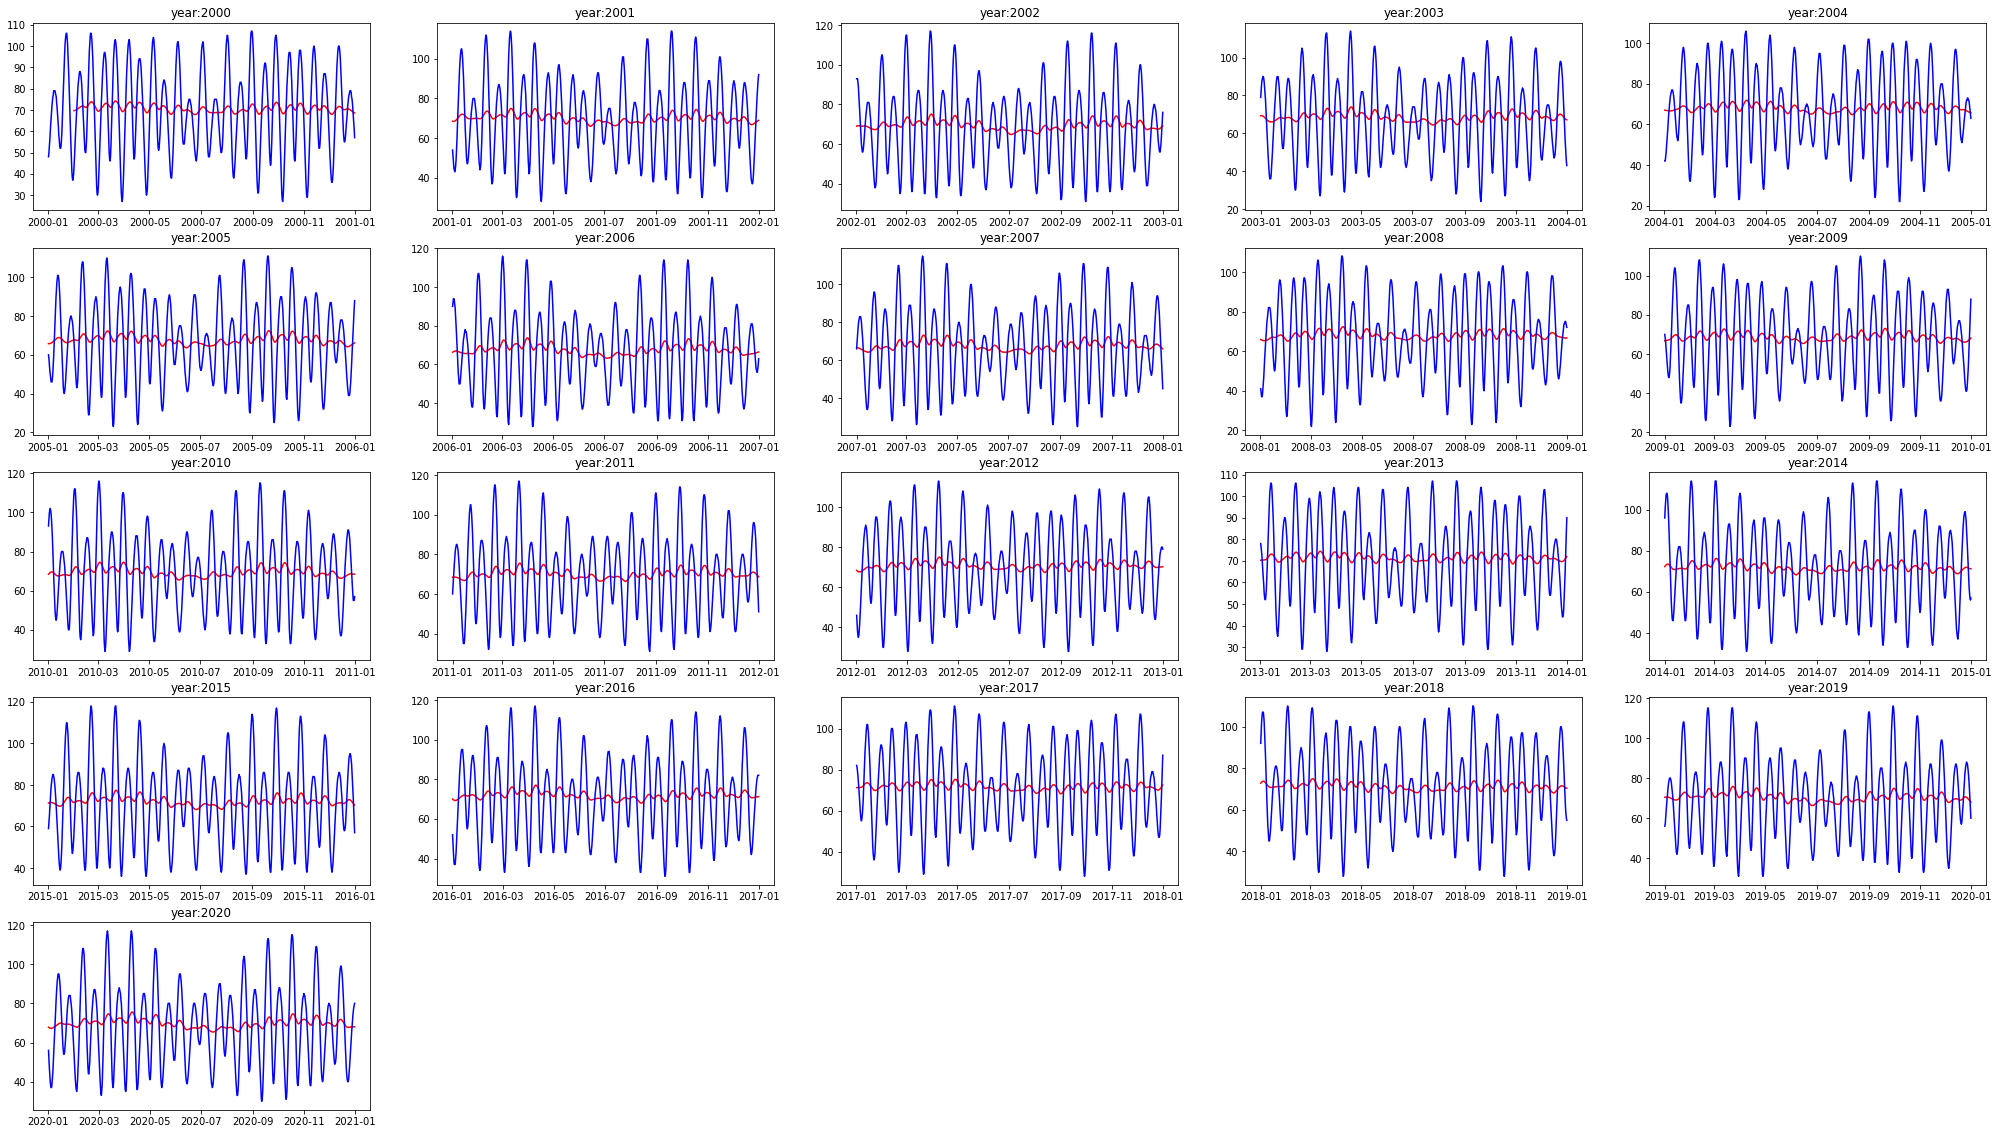

In [23]:
df['mean'] = df.loc[:,"coef"].rolling(window=60).mean() # Moving average of one month 
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    plt.plot(data["dateTime"], data["mean"], 'r-')
    plt.plot(data["dateTime"], data["coef"], color ='blue')
    plt.title("year:"+ str(years[i]))

- Well since the variance change over time! Also the past plots show a strong seasonal effect so we would say at this stage it is not stationary 
  Althoug the mean is basically constant !

Let's check using the Dicky-fuller test.

In [25]:
X = df["coef"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.416285
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


the p-value of the test is 0 this suggests the rejection of the null hypothesis, which claims for non-stationarity

- Let's check for only one year

In [26]:
X = df[df["year"]==2020]["coef"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.859436
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


So rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

# Is there a seasonality?


Time series datasets can contain a seasonal component.

This is a cycle that repeats over time, such as monthly or yearly. 

This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models.

Text(0.5, 1.0, 'year:2000')

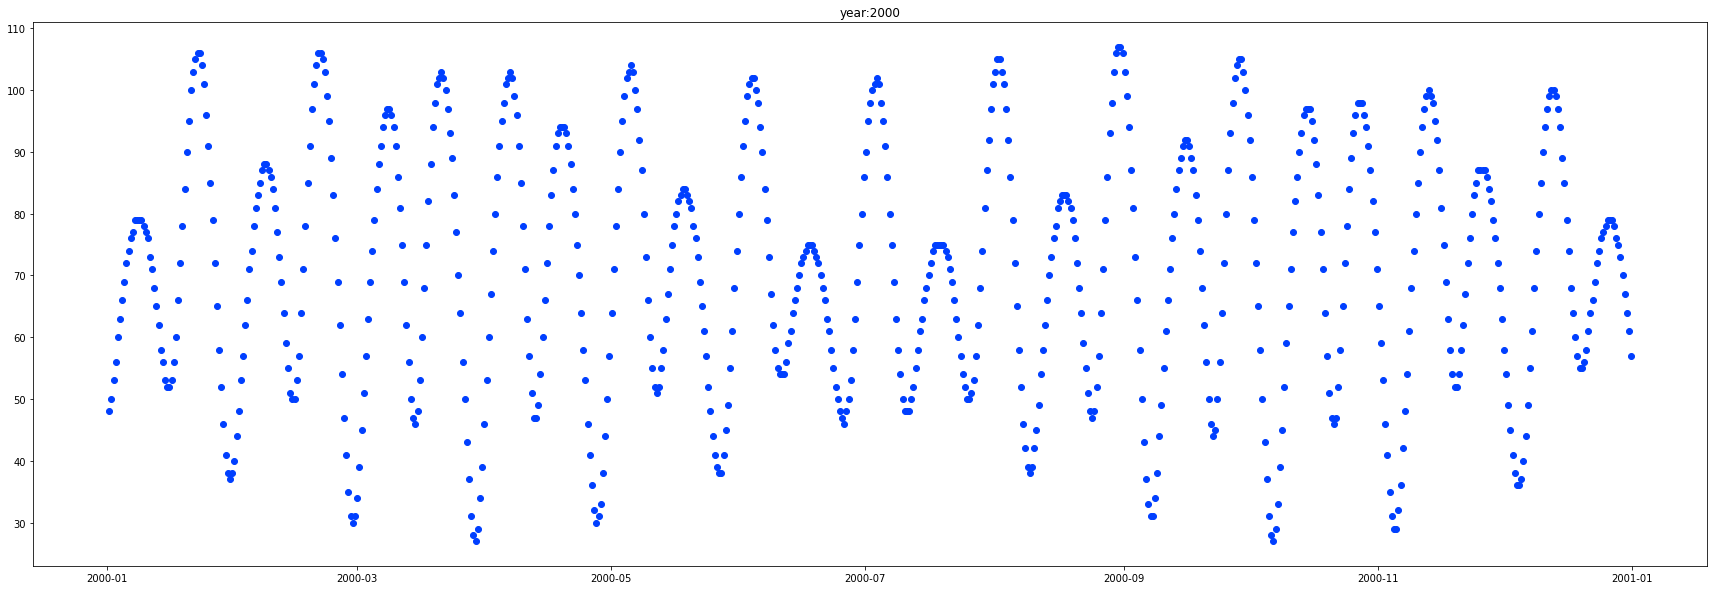

In [27]:
plt.figure(figsize=(30,10))
data = df[df["year"] == 2000]
plt.scatter(data["dateTime"], data["coef"])
plt.title("year:"+ str(2000))

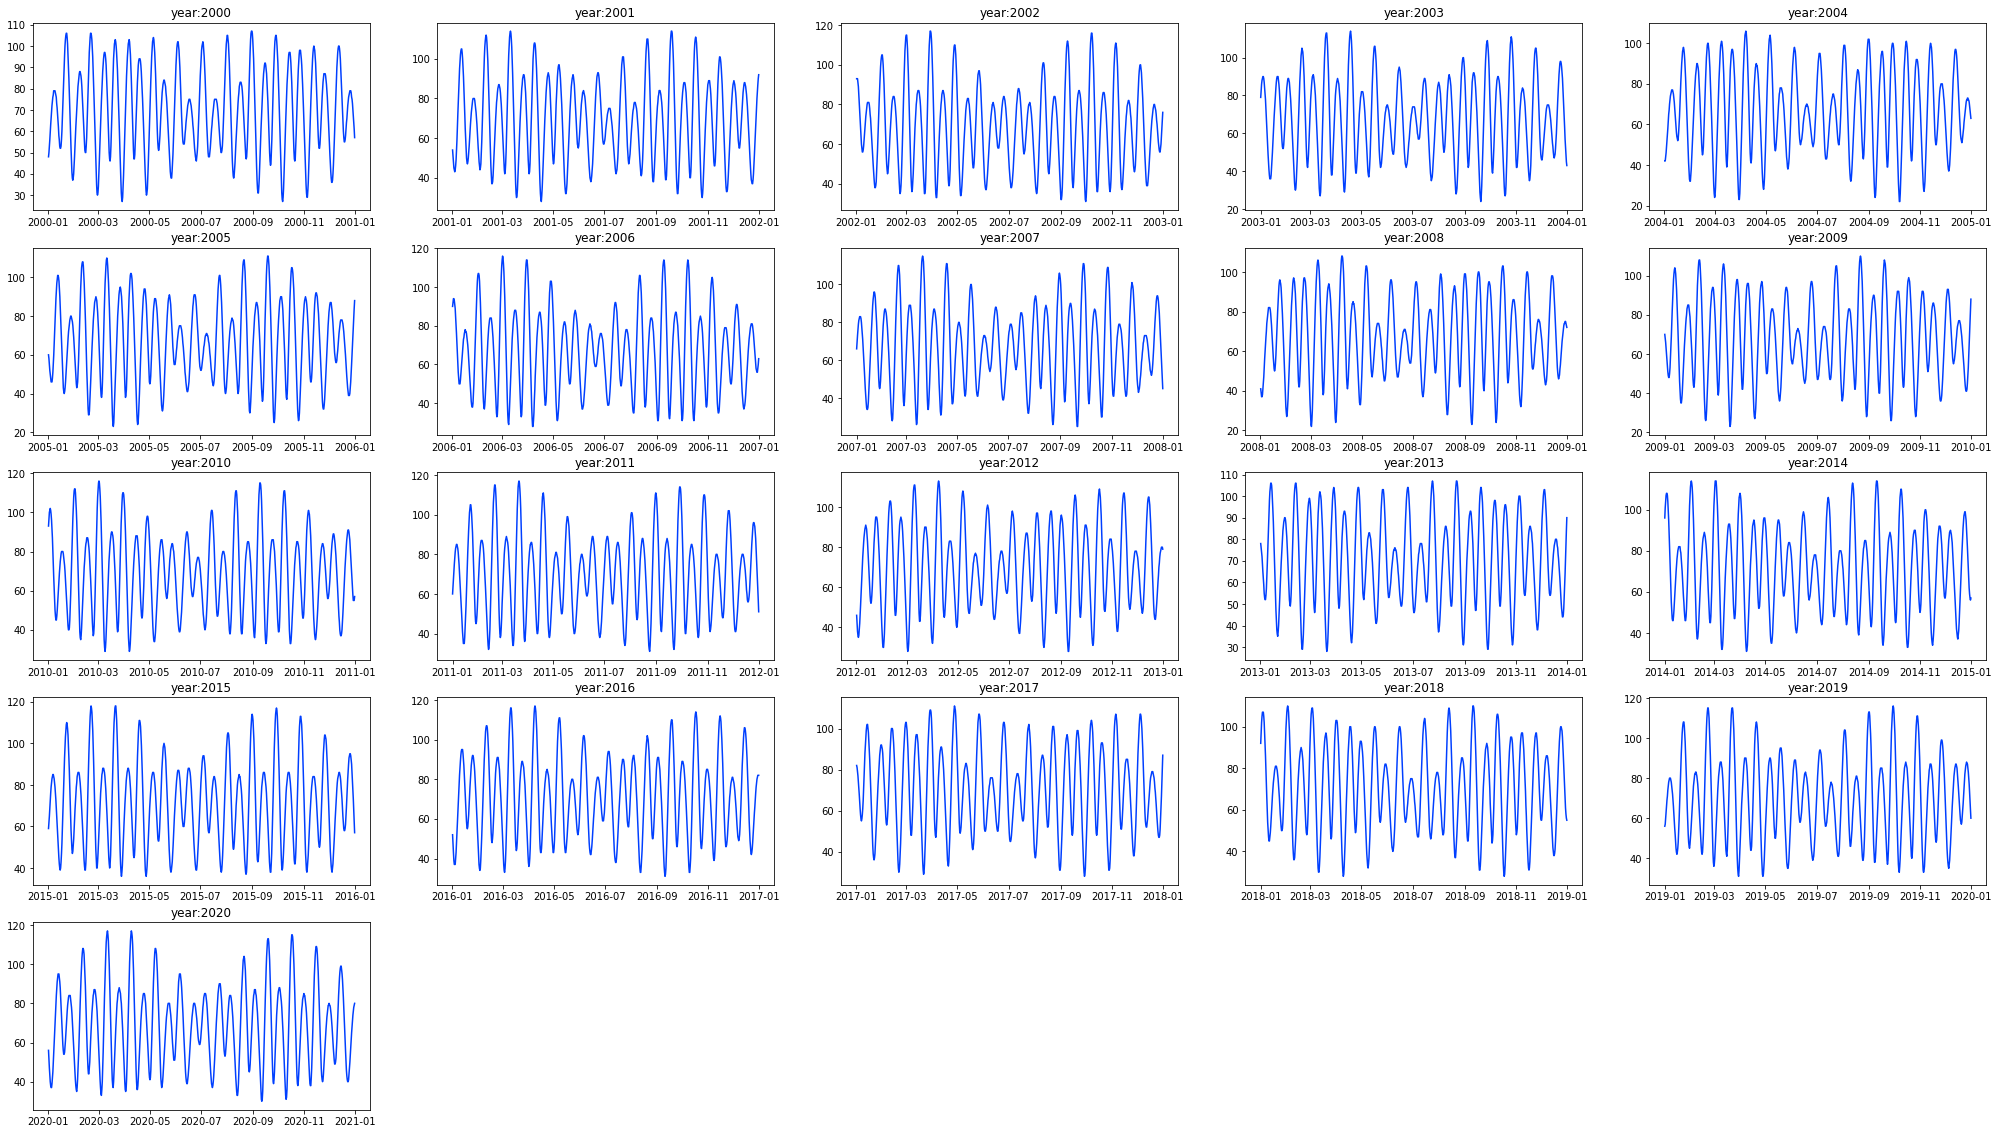

In [28]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    plt.plot(data["dateTime"], data["coef"])
    plt.title("year:"+ str(years[i]))

Seeing the plots above it seams that there is seasonality (6-month pattern),
but observing the last plot, we could say that our data is seasonal-stationary, let's check by computing the autocorrelation

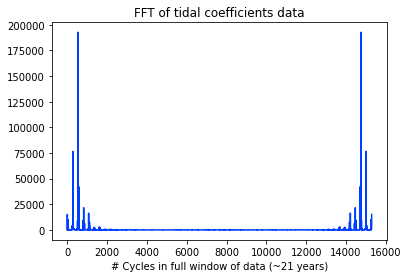

In [29]:
Fft = fft((df.coef - df.coef.mean()).values)
plt.plot(np.abs(Fft))
plt.title("FFT of tidal coefficients data")
plt.xlabel('# Cycles in full window of data (~21 years)');

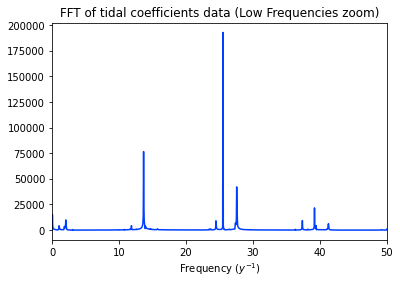

In [30]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([0,50])
plt.xlabel('Frequency ($y^{-1}$)');

- we see that there is a weekly seasonality

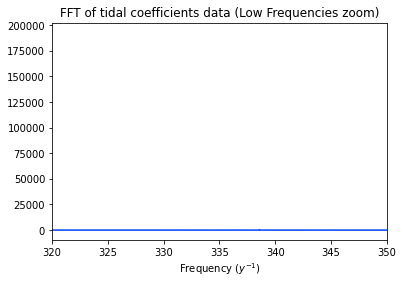

In [31]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([320,350])
plt.xlabel('Frequency ($y^{-1}$)');

- 13 day seasonality

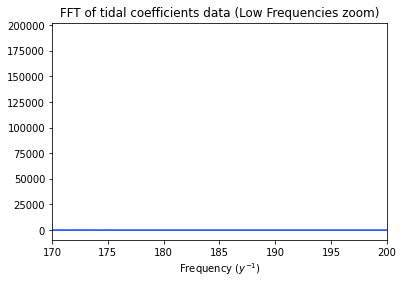

In [32]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([170,200])
plt.xlabel('Frequency ($y^{-1}$)');

- no 6 months seasonality

Let's check seasonality by plotting autocorrelation plot

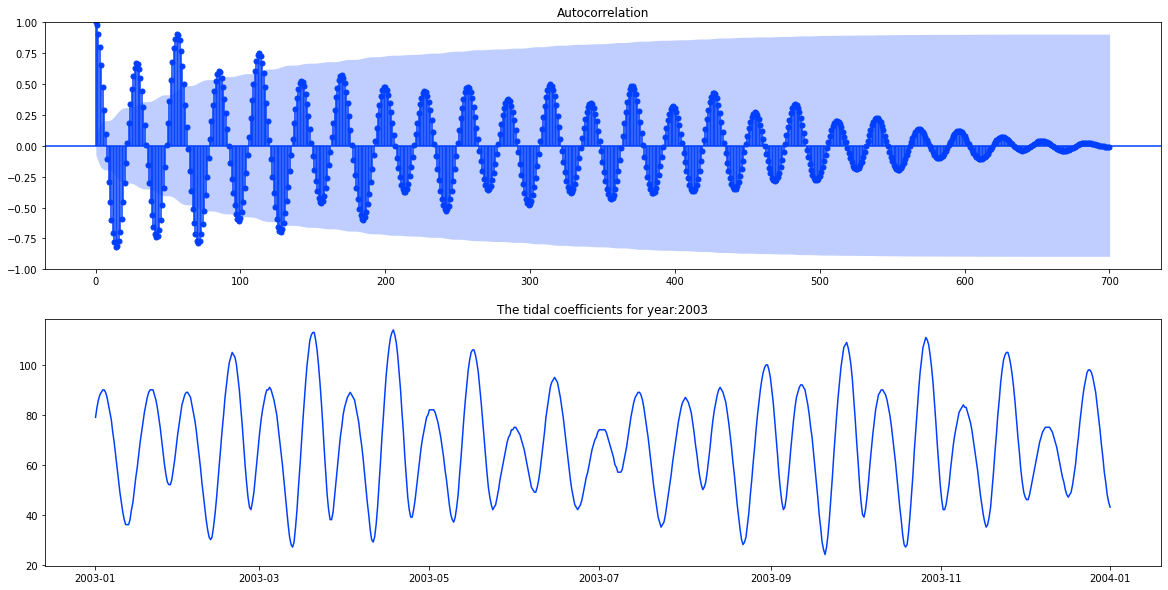

In [33]:
year = 2003
fig, ax = plt.subplots(2,1, figsize=(20,10))
plot_acf(df[df["year"]==year].coef, lags =700, ax=ax[0])
plt.plot(df[df["year"]==year].dateTime, df[df["year"]==year].coef)
plt.title("The tidal coefficients for year:" + str(year));

- We see cycles of strong negative and positive correlation.

- Sine waves like those are a strong sign of seasonality in the dataset.

- An ACF fails to
    weed out these redundant correlations.
- The PACF, on the other hand, reveals which
    correlations are “true” informative correlations for specific lags rather than redun‐
    dancies. This is invaluable for knowing when we have collected enough information
    to get a sufficiently long window at a proper temporal scale for our data.

C:\Users\Otmane\anaconda3\envs\prediciton_of_tidal_coefficient\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


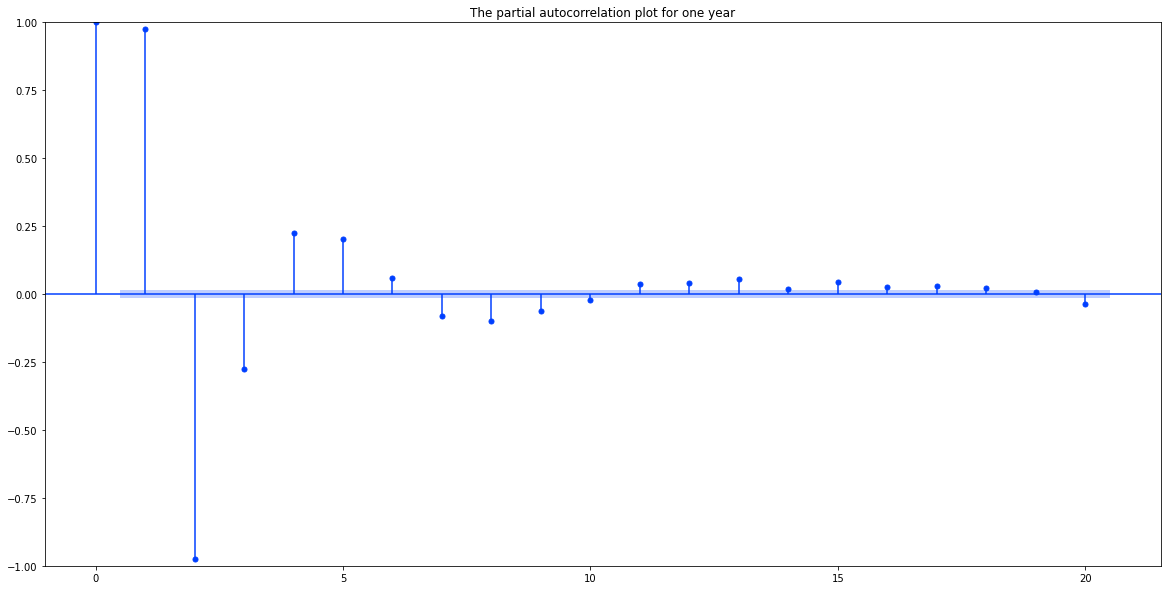

In [34]:
year = 2000
fig, ax = plt.subplots(figsize=(20,10))
plot_pacf(df.coef, lags =20, ax = ax)
plt.title("The partial autocorrelation plot for one year");

# Problem Description

I' ll formulate the tidal coefficients forecasting as a supervised machine
learning task.

Given a time series containing N data points xt-(N+1);...; xt-1; xt, for M-step
ahead prediction. 

The input X of the supervised
ML model is xt-(N+1);....; xt-M, and the output Y is
xt-(M+1); xt-(M+2);...; xt.

Each data point xt can be a scalar
or a vector containing multiple features.

So it's a Seq2Seq problem.

So data must be prepared using the moving window technique to create features for the Seq2Seq model


### Evaluation metric

Several metrics are used in the litterature for time series forcasting, each metrics has it's advantages and drowbacks or limitation. And it's really context sensitive. Since this nootebook is exploratory. I'll go with the RMSE. And I'll evaluate each timeStamp individually. Which means RMSE for prediction of day1, RMSE for predicition day2...

In [35]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

### Data preparation

We will use the first 20 years of data for training predictive models and the final year for evaluating models.

The data will be divided into weeks, 14 values  (since for each day we've computed 2 values of the tidal coefficient). And the next 14 values would constitute the prediction target for the models.

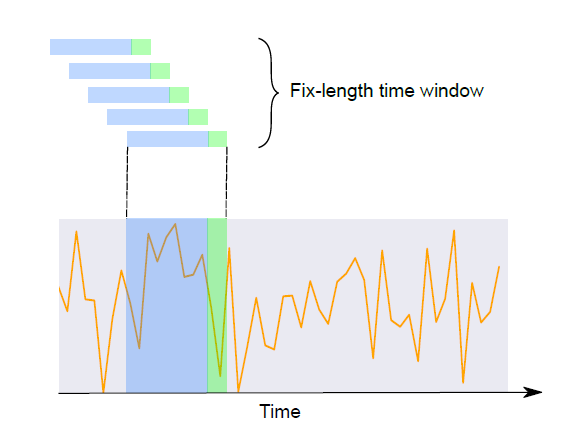

In [36]:
def split_dataset(data, past_values = 14, step = 14):
    """ Takes a dateTime with timeStamp and coef columns
        and creates train and test data by sliding a fixed size window
    """
    data['year'] = data['dateTime'].dt.year.values
    # split train and test
    train, test = data[data['year']!=2021].coef.values , data[data['year']==2021].coef.values
    # restructure into windows of weekly data
    X_train, y_train = [], []
    X_test, y_test = [], []
    train_shape = train.shape
    test_shape = test.shape
    print(train_shape)
    for row in range(0, train_shape[0]):
        if row+past_values+step <= train_shape[0]:
            X_train.append(train[row:row+past_values].reshape(past_values, 1))
            y_train.append(train[row+past_values:row+past_values+step])
    for row in range(0, test_shape[0]):
        if row+past_values+step <= test_shape[0]:
            X_test.append(test[row:row+past_values].reshape(past_values, 1))
            y_test.append(test[row+past_values:row+past_values+step])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [37]:
X_train, X_test, y_train, y_test = split_dataset(df.drop(axis=1,columns = ["month", "year", "day", "time", "hour", "mean"]))

(14822,)


In [38]:
X_train.shape

(14795, 14, 1)

In [40]:
from sklearn.model_selection import TimeSeriesSplit

In [43]:
def crossValidationData(X_train, y_train, n_splits = 10):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        # Getting splits indexes
        train_index = tscv.split(X_train)
        print(train_index)
        X_train = X_train[train_index]
        y_train = y_train[train_index]
        return X_train, y_train

In [44]:
X_train, y_train = crossValidationData(X_train, y_train)

<generator object TimeSeriesSplit.split at 0x0000022A8843D580>


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### RF: fast proof of concept

In [98]:
X_train_shape = X_train.shape
X_test_shape = X_test.shape

In [99]:
RF = RandomForestRegressor(n_estimators = 100)
RF.fit(X_train.reshape(X_train_shape[0], X_train_shape[1]),y_train)

RandomForestRegressor()

In [100]:
y_predicted = RF.predict(X_test.reshape(X_test_shape[0],X_test_shape[1]))

In [103]:
score, scores = evaluate_forecasts(y_test, y_predicted)

the RMSE for all predictions is:6.347429142999361
----------------------------------------------------------------------------------------------------


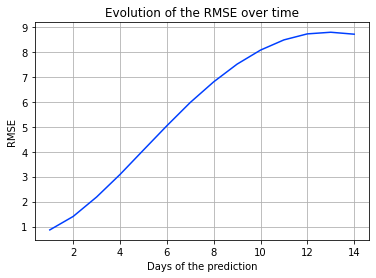

In [104]:
print("the RMSE for all predictions is:{}".format(score))

print("-"*100)

plt.plot(np.arange(14)+1, scores)
plt.xlabel("Days of the prediction")
plt.ylabel("RMSE")
plt.grid()
plt.title("Evolution of the RMSE over time");

- The errors above indicate that our model performs well for the first value of the first day prediction and it does worse as we want to predict further steps in time. But Since the RMSE computed here has the same unit "roughly speaking: our actual value has no unit".

Plotting actual versus predicted forcast of tidal coefficients

In [117]:
def plot_forcast(X, y, y_pred, data_index):
    plt.figure(figsize = (20,10))
    past_values = len(X[0])
    step = len(y[0])
    # Input 
    plt.scatter(np.arange(past_values)+1, X[data_index], color = "red")
    plt.plot(np.arange(past_values)+1, X[data_index], color = "red")

    # Ouptut (actual)
    plt.scatter(np.arange(past_values)+step+1, y[data_index], color = "red")
    plt.plot(np.arange(past_values)+step+1, y[data_index], color = "red", label = "actual")

    # Ouput (predicted)
    plt.scatter(np.arange(past_values)+step+1, y_pred[data_index], color ="blue")
    plt.plot(np.arange(past_values)+step+1, y_pred[data_index], color = "blue",  label = "predicted")

    # Decoration
    plt.axvline(x=step, color = "black")
    plt.axvspan(step, step+past_values, alpha=0.5, color='silver')
    
    plt.ylabel("Tidal coef value")
    plt.title("Foracast of {} days ahead using values from {} past days".format(step, past_values))
    plt.legend()
    plt.grid();
    

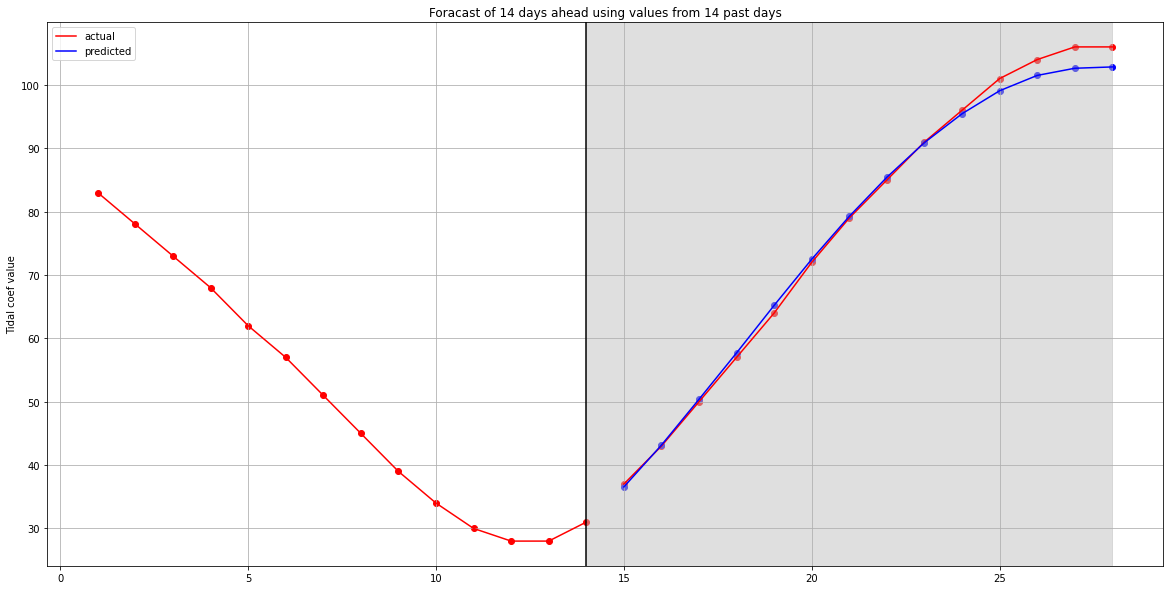

In [118]:
plot_forcast(X_test, y_test, y_predicted, 88)

### Conclusion